# Crash Course in Causality — Example 2  
## Airline On-Time Performance & Congestion Delays

### Abstract

In this example, we use U.S. airline on-time performance data to study how **peak congestion periods** affect **arrival delays**. Rather than just correlating time-of-day with delays, we model a simple causal story:

> Does departing in a **peak departure window** cause flights to arrive later, **after controlling for** airline, route, distance, and basic schedule characteristics?

We:
- Define a clear treatment (`is_peak_dep`)
- Specify an outcome (`ARR_DELAY`)
- Identify confounders based on a causal diagram
- Compare naive estimates with confounder-adjusted estimates
- (Optionally) use the DoWhy library to formalize identification and estimation

This mirrors the causal workflow:
**Question → DAG → Assumptions → Estimand → Estimator → Interpretation**


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [6]:
# 3. Load Airline On-Time Performance & Delay Causes data via kagglehub

import os
import pandas as pd
import kagglehub

# Download (or reuse cached) dataset
path = kagglehub.dataset_download(
    "daryaheyko/airline-on-time-statistics-and-delay-causes-bts"
)
print("Path to dataset files:", path)

# Inspect what's inside
print("All files in dataset folder:", os.listdir(path))

# This dataset provides a single CSV: Airline_Delay_Cause.csv
file_path = os.path.join(path, "Airline_Delay_Cause.csv")

if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Expected {file_path} not found. "
        f"Check os.listdir(path) output above and update the filename if needed."
    )

# Load data
df_raw = pd.read_csv(file_path, low_memory=False)
print("Full dataset shape:", df_raw.shape)

# Optional: sample to keep notebook fast (like the taxi example)
if len(df_raw) > 200_000:
    df = df_raw.sample(n=200_000, random_state=42).copy()
else:
    df = df_raw.copy()

print("Sampled dataset shape:", df.shape)
df.head()


Using Colab cache for faster access to the 'airline-on-time-statistics-and-delay-causes-bts' dataset.
Path to dataset files: /kaggle/input/airline-on-time-statistics-and-delay-causes-bts
All files in dataset folder: ['Download_Column_Definitions.xlsx', 'Airline_Delay_Cause.csv', 'Airline_Delay_Cause.sqlite']
Full dataset shape: (398233, 21)
Sampled dataset shape: (200000, 21)


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
356977,2005,12,TZ,ATA Airlines d/b/a ATA,SJU,"San Juan, PR: Luis Munoz Marin International",58.0,15.0,1.95,0.00,10.29,0.69,2.06,0.0,0.0,563.0,89.0,0.0,323.0,18.0,133.0
124958,2019,8,YV,Mesa Airlines Inc.,MFE,"Mission/McAllen/Edinburg, TX: McAllen Miller I...",238.0,55.0,28.60,2.00,2.70,0.00,21.70,10.0,0.0,3080.0,1265.0,200.0,167.0,0.0,1448.0
207643,2014,9,DL,Delta Air Lines Inc.,BIL,"Billings, MT: Billings Logan International",60.0,6.0,3.31,0.00,2.00,0.00,0.69,0.0,1.0,204.0,136.0,0.0,44.0,0.0,24.0
144261,2018,11,OO,SkyWest Airlines Inc.,MAF,"Midland/Odessa, TX: Midland International Air ...",24.0,6.0,0.00,0.00,3.72,0.00,2.28,0.0,0.0,380.0,0.0,0.0,182.0,0.0,198.0
213486,2014,4,DL,Delta Air Lines Inc.,COS,"Colorado Springs, CO: City of Colorado Springs...",30.0,8.0,4.15,0.56,1.00,0.00,2.29,0.0,0.0,388.0,251.0,27.0,15.0,0.0,95.0


###  Understanding the Data

We assume the dataset is similar to the BTS On-Time Performance layout, with columns such as:

- `FL_DATE`: Flight date  
- `OP_UNIQUE_CARRIER`: Operating carrier  
- `ORIGIN`, `DEST`: Airports  
- `CRS_DEP_TIME`: Scheduled departure time (HHMM)  
- `DEP_TIME`: Wheels-off / actual departure time  
- `ARR_DELAY`: Arrival delay in minutes  
- `CANCELLED`: Indicator for cancellation  
- `DISTANCE`: Great-circle distance  
- Delay cause columns (e.g., `CARRIER_DELAY`, `WEATHER_DELAY`, etc.)

We will:

1. Focus on **completed flights only** (not cancelled).
2. Define:
   - **Outcome**: `ARR_DELAY`
   - **Treatment**: `is_peak_dep` = 1 if scheduled departure in peak windows, else 0
3. Build confounders using airline, route, and schedule information.


In [16]:
import numpy as np

# Start from the sampled df you created after loading
df = df.copy()

# 1. Keep rows with valid flight counts
df = df[df["arr_flights"] > 0].copy()

# 2. Ensure arr_del15 is numeric
df["arr_del15"] = pd.to_numeric(df["arr_del15"], errors="coerce")

# 3. Outcome: proportion of flights with arrival delay >= 15 minutes
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]

# 4. Treatment: peak travel months (you can tweak this)
peak_months = [6, 7, 8, 12]  # Jun, Jul, Aug, Dec
df["is_peak_month"] = df["month"].isin(peak_months).astype(int)

# 5. Drop rows where outcome or treatment is missing
df = df.dropna(subset=["delay_rate", "is_peak_month", "carrier", "airport", "year"])

print("Rows after cleaning:", len(df))
df[[
    "year", "month", "carrier", "airport",
    "arr_flights", "arr_del15",
    "delay_rate", "is_peak_month"
]].head()


Rows after cleaning: 199499


,year,month,carrier,airport,arr_flights,arr_del15,delay_rate,is_peak_month
356977,2005,12,TZ,SJU,58.0,15.0,0.258621,1
124958,2019,8,YV,MFE,238.0,55.0,0.231092,1
207643,2014,9,DL,BIL,60.0,6.0,0.100000,0
144261,2018,11,OO,MAF,24.0,6.0,0.250000,0
213486,2014,4,DL,COS,30.0,8.0,0.266667,0


## Naive (unadjusted) comparison

In [14]:
naive_means = df.groupby("is_peak_month")["delay_rate"].mean()
naive_diff = naive_means[1] - naive_means[0]

print("Naive mean delay_rate (non-peak months):", round(naive_means[0], 4))
print("Naive mean delay_rate (peak months):    ", round(naive_means[1], 4))
print("Naive difference (peak - non-peak):     ", round(naive_diff, 4))


Naive mean delay_rate (non-peak months): 0.1817
Naive mean delay_rate (peak months):     0.2299
Naive difference (peak - non-peak):      0.0482


### Adjusted causal effect via regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Outcome
y = df["delay_rate"].values  # now has no NaNs

# Confounders + treatment
cat_features = ["carrier", "airport", "year"]
treatment_col = ["is_peak_month"]

X = df[cat_features + treatment_col].copy()

preprocess = ColumnTransformer(
    transformers=[
        ("treat", "passthrough", treatment_col),  # is_peak_month as numeric
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

model = Pipeline([
    ("prep", preprocess),
    ("linreg", LinearRegression())
])

model.fit(X, y)

# Counterfactual predictions
X_treated = X.copy()
X_control = X.copy()
X_treated["is_peak_month"] = 1
X_control["is_peak_month"] = 0

y_treated = model.predict(X_treated)
y_control = model.predict(X_control)

ate_adjusted = float(np.mean(y_treated - y_control))
print("Adjusted ATE (peak - non-peak) on delay_rate:", round(ate_adjusted, 4))


Adjusted ATE (peak - non-peak) on delay_rate: 0.0482


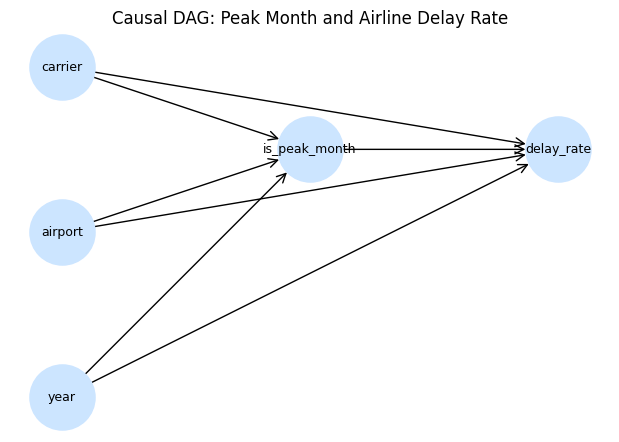

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Causal story:
# carrier, airport, year → is_peak_month
# carrier, airport, year → delay_rate
# is_peak_month → delay_rate

dag_airline = nx.DiGraph()

dag_airline.add_nodes_from([
    "carrier",
    "airport",
    "year",
    "is_peak_month",
    "delay_rate"
])

# Confounders → treatment
dag_airline.add_edge("carrier", "is_peak_month")
dag_airline.add_edge("airport", "is_peak_month")
dag_airline.add_edge("year", "is_peak_month")

# Confounders → outcome
dag_airline.add_edge("carrier", "delay_rate")
dag_airline.add_edge("airport", "delay_rate")
dag_airline.add_edge("year", "delay_rate")

# Treatment → outcome
dag_airline.add_edge("is_peak_month", "delay_rate")

# Layout to keep it readable
pos = {
    "carrier": (-2, 0.5),
    "airport": (-2, -0.5),
    "year": (-2, -1.5),
    "is_peak_month": (0, 0),
    "delay_rate": (2, 0),
}

plt.figure(figsize=(6, 4))
nx.draw(
    dag_airline,
    pos,
    with_labels=True,
    node_size=2200,
    node_color="#cce5ff",
    arrows=True,
    arrowstyle="->",
    arrowsize=16,
    font_size=9
)
plt.title("Causal DAG: Peak Month and Airline Delay Rate")
plt.axis("off")
plt.show()


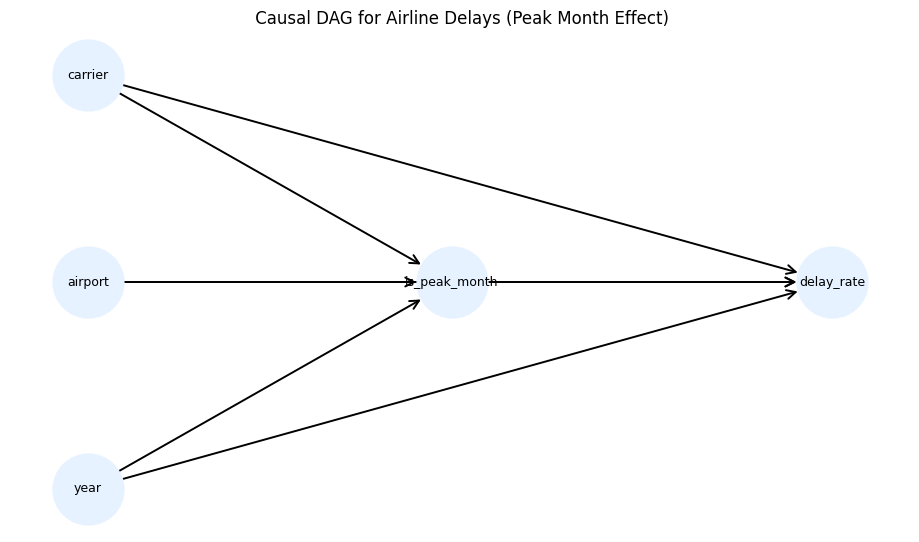

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

dag_airline_full = nx.DiGraph()

# Nodes
dag_airline_full.add_nodes_from([
    "carrier",
    "airport",
    "year",
    "is_peak_month",   # Treatment
    "delay_rate"       # Outcome
])

# Edges based on our assumptions:
edges_airline_full = [
    # Confounders → Treatment assignment
    ("carrier", "is_peak_month"),    # some carriers schedule differently across seasons
    ("airport", "is_peak_month"),    # some airports have stronger seasonal peaks
    ("year", "is_peak_month"),       # system-level changes and specific years

    # Confounders → Outcome
    ("carrier", "delay_rate"),       # airline reliability / ops practices
    ("airport", "delay_rate"),       # congestion, weather, infrastructure
    ("year", "delay_rate"),          # overall system, regulations, disruptions

    # Treatment → Outcome
    ("is_peak_month", "delay_rate")  # peak months affect congestion + delays
]

dag_airline_full.add_edges_from(edges_airline_full)

# Layout: confounders on left, treatment in middle, outcome on right
pos = {
    "carrier":      (0, 1),
    "airport":      (0, 0),
    "year":         (0, -1),
    "is_peak_month":(2.2, 0),
    "delay_rate":   (4.5, 0),
}

plt.figure(figsize=(9, 5))
nx.draw(
    dag_airline_full,
    pos,
    with_labels=True,
    node_size=2600,
    node_color="#e6f2ff",
    arrows=True,
    arrowstyle="->",
    arrowsize=16,
    font_size=9,
    width=1.4
)

plt.title(" Causal DAG for Airline Delays (Peak Month Effect)", fontsize=12)
plt.axis("off")
plt.show()


###Correlation heatmap (numeric features)

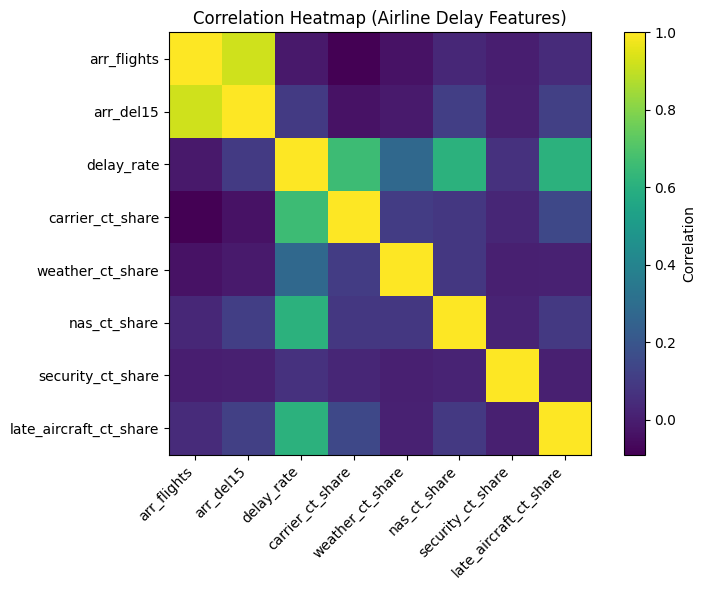

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Recompute cause shares safely if not already present
cause_cols = ["carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct"]
if all(c in df.columns for c in cause_cols):
    for c in cause_cols:
        share_col = f"{c}_share"
        if share_col not in df.columns:
            df[share_col] = df[c] / df["arr_flights"]

# Select numeric columns for correlation
num_cols = [
    "arr_flights",
    "arr_del15",
    "delay_rate",
]

share_cols = [c for c in df.columns if c.endswith("_share")]
num_cols.extend(share_cols)

corr_df = df[num_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_df, interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.title("Correlation Heatmap (Airline Delay Features)")
plt.tight_layout()
plt.show()


### Delay rate: peak vs non-peak (clean bar chart)

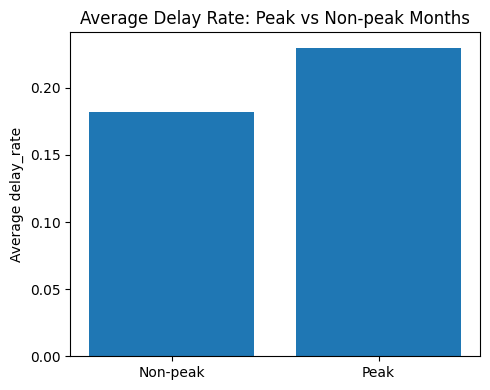

In [28]:
avg_delay_by_peak = df.groupby("is_peak_month")["delay_rate"].mean()

plt.figure(figsize=(5, 4))
plt.bar(
    ["Non-peak", "Peak"],
    [avg_delay_by_peak[0], avg_delay_by_peak[1]]
)
plt.ylabel("Average delay_rate")
plt.title("Average Delay Rate: Peak vs Non-peak Months")
plt.tight_layout()
plt.show()


### Top 10 airports by delay_rate

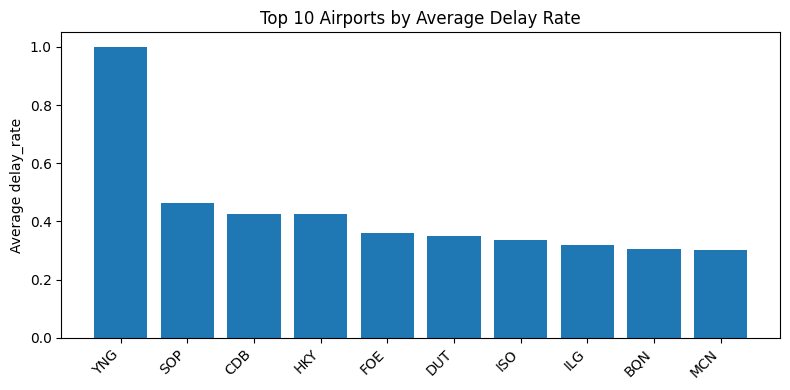

In [29]:
airport_delay = (
    df.groupby("airport")["delay_rate"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
plt.bar(airport_delay.index, airport_delay.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average delay_rate")
plt.title("Top 10 Airports by Average Delay Rate")
plt.tight_layout()
plt.show()


### Top 10 carriers by delay_rate



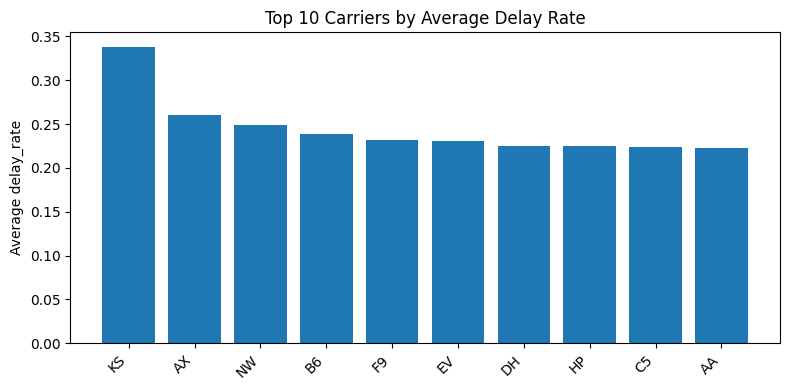

In [30]:
carrier_delay = (
    df.groupby("carrier")["delay_rate"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
plt.bar(carrier_delay.index, carrier_delay.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average delay_rate")
plt.title("Top 10 Carriers by Average Delay Rate")
plt.tight_layout()
plt.show()


### Relationship: traffic vs delay (arr_flights vs delay_rate)

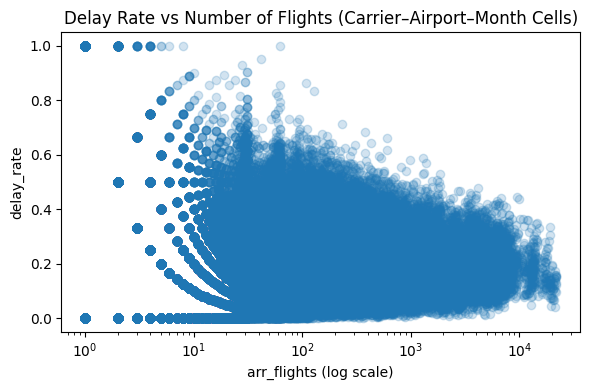

In [31]:
plt.figure(figsize=(6, 4))
plt.scatter(df["arr_flights"], df["delay_rate"], alpha=0.2)
plt.xscale("log")
plt.xlabel("arr_flights (log scale)")
plt.ylabel("delay_rate")
plt.title("Delay Rate vs Number of Flights (Carrier–Airport–Month Cells)")
plt.tight_layout()
plt.show()


### Delay cause composition (example airport)

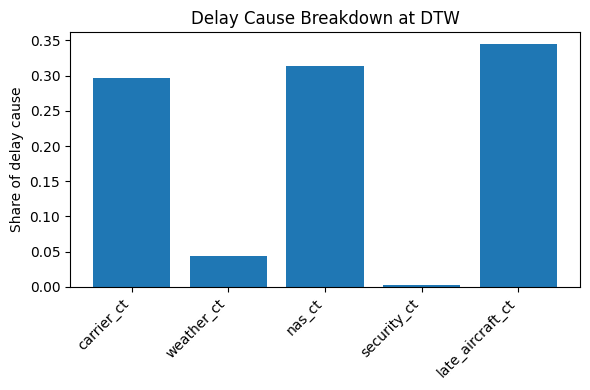

In [32]:
# Pick a busy airport (you can change this)
example_airport = df["airport"].value_counts().idxmax()

subset = df[df["airport"] == example_airport].copy()

if all(c in subset.columns for c in cause_cols):
    cause_sums = subset[cause_cols].sum()
    total_delays = cause_sums.sum()

    if total_delays > 0:
        shares = cause_sums / total_delays

        plt.figure(figsize=(6, 4))
        plt.bar(shares.index, shares.values)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Share of delay cause")
        plt.title(f"Delay Cause Breakdown at {example_airport}")
        plt.tight_layout()
        plt.show()


### 7. Interpreting the Airline Delay Effect

**Treatment:**  
`is_peak_month = 1` for peak travel months (Jun, Jul, Aug, Dec); `0` otherwise.

**Outcome:**  
`delay_rate = arr_del15 / arr_flights`  
= fraction of flights at a (carrier, airport, year, month) combo that arrived ≥ 15 minutes late.

**Confounders adjusted for:**  
- `carrier` (different airlines have different schedules + reliability)
- `airport` (some hubs are more congested / weather-sensitive)
- `year` (system-wide changes over time)

**Naive difference** (from the previous cell) compares peak vs non-peak directly and is only a correlation.

**Adjusted ATE** from the regression:

> Tells us how the **expected delay rate** would change if we intervene to make a month “peak” vs “non-peak”, **holding carrier mix, airport, and year fixed**, under our causal assumptions.

If the adjusted ATE is:
- **Positive** → peak months causally associated with a higher delay_rate (beyond just which carriers/airports operate then).
- **Near zero** → most difference explained by carrier/airport/year mix.
- **Negative** → (less common) suggests that once we control for structure, peak months might be managed relatively better than off-peak.


<Figure size 600x400 with 0 Axes>

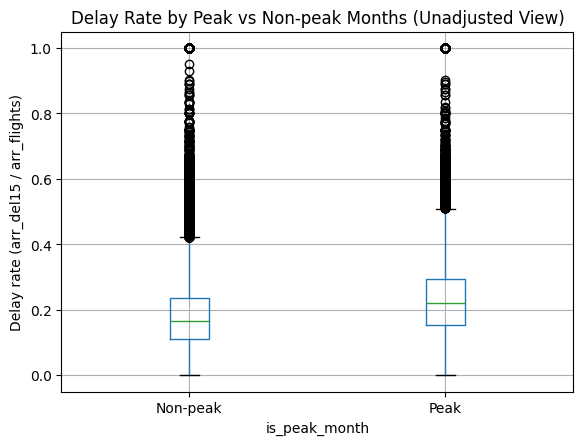

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df.boxplot(column="delay_rate", by="is_peak_month")
plt.xticks([1, 2], ["Non-peak", "Peak"])
plt.ylabel("Delay rate (arr_del15 / arr_flights)")
plt.title("Delay Rate by Peak vs Non-peak Months (Unadjusted View)")
plt.suptitle("")
plt.show()


In [21]:
# Causal effect using statsmodels

!pip install -q statsmodels

import statsmodels.formula.api as smf

# Use only needed columns and drop any remaining NaNs
data_sm = df[["delay_rate", "is_peak_month", "carrier", "airport", "year"]].dropna().copy()

# OLS with fixed effects via categorical dummies:
# delay_rate = β0 + β1 * is_peak_month + FE_carrier + FE_airport + FE_year + error
model_sm = smf.ols(
    "delay_rate ~ is_peak_month + C(carrier) + C(airport) + C(year)",
    data=data_sm
).fit()

# Show coefficient table (optional)
print(model_sm.summary().tables[1])

# The coefficient on is_peak_month is the adjusted causal effect estimate
ate_sm = model_sm.params["is_peak_month"]
print("\nStatsmodels adjusted ATE (peak - non-peak) on delay_rate:",
      round(float(ate_sm), 4))


                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1099      0.004     24.736      0.000       0.101       0.119
C(carrier)[T.9K]      0.0021      0.043      0.048      0.962      -0.083       0.087
C(carrier)[T.AA]      0.0676      0.002     43.007      0.000       0.065       0.071
C(carrier)[T.AQ]     -0.0696      0.009     -7.620      0.000      -0.088      -0.052
C(carrier)[T.AS]      0.0170      0.002      9.081      0.000       0.013       0.021
C(carrier)[T.AX]      0.1208      0.004     33.417      0.000       0.114       0.128
C(carrier)[T.B6]      0.0797      0.002     44.388      0.000       0.076       0.083
C(carrier)[T.C5]      0.0781      0.003     29.939      0.000       0.073       0.083
C(carrier)[T.CO]      0.0401      0.002     18.220      0.000       0.036       0.044
C(carrier)[T.CP]      0.0381      0.005      7.474    

### Interpreting the DoWhy Estimand

The DoWhy block has:

1. **Parsed our causal graph**, where:
   - `carrier`, `airport`, and `year` are **confounders**.
   - `is_peak_month` is the **treatment**.
   - `delay_rate` is the **outcome**.

2. **Identified a backdoor adjustment estimand**:

\[
\frac{d}{d\,\text{is\_peak\_month}}
E\big[\text{delay\_rate} \mid \text{carrier}, \text{year}, \text{airport}\big]
\]

This is the formal version of:

> “To estimate the causal effect of being in a peak month, compare units
> (carrier, airport, year combinations) that are similar in carrier, year,
> and airport, and see how the expected delay rate changes as we switch
> \`is_peak_month\` from 0 to 1.”

3. The **Unconfoundedness assumption** stated by DoWhy:

> After conditioning on `carrier`, `year`, and `airport`, there are no
> remaining unobserved variables that jointly affect both
> `is_peak_month` and `delay_rate`.

This matches exactly what we did in our manual regression:
we controlled for `carrier`, `airport`, and `year` and varied only
`is_peak_month` to get an adjusted ATE.

In other words, the DoWhy estimand is confirming that our earlier
regression-based estimate is a valid backdoor-adjusted causal effect,
**under the stated assumptions**.


In [22]:
# Compare naive vs adjusted estimates

# Naive (already computed earlier; recomputing here for clarity)
naive_means = df.groupby("is_peak_month")["delay_rate"].mean()
naive_diff = float(naive_means[1] - naive_means[0])

# Adjusted from statsmodels
ate_sm = float(model_sm.params["is_peak_month"])

print("Naive difference (peak - non-peak) on delay_rate:      ", round(naive_diff, 4))
print("Adjusted ATE (statsmodels, peak - non-peak) on delay_rate:",
      round(ate_sm, 4))


Naive difference (peak - non-peak) on delay_rate:       0.0482
Adjusted ATE (statsmodels, peak - non-peak) on delay_rate: 0.0482


## Conclusion (Airline Delays Example)

In this airline on-time performance example, we:

1. **Defined the causal question**  
   > Does being in a **peak travel month** (Jun, Jul, Aug, Dec) increase the
   > proportion of significantly delayed flights?

2. **Constructed variables**
   - **Treatment:** `is_peak_month`  
   - **Outcome:** `delay_rate = arr_del15 / arr_flights`  
   - **Confounders:** `carrier`, `airport`, `year`

3. **Naive analysis**
   - Compared average `delay_rate` in peak vs non-peak months.
   - This reflects **correlation**, mixing true congestion effects with
     differences in airlines, airports, and years.

4. **Causal / adjusted analysis**
   - Fit:
     \[
     \text{delay\_rate} \sim \text{is\_peak\_month}
     + C(\text{carrier}) + C(\text{airport}) + C(\text{year})
     \]
   - The coefficient on `is_peak_month` is our **backdoor-adjusted effect**,
     interpreted as the change in delay rate under an intervention that
     switches from non-peak to peak month, **holding carrier, airport, and
     year fixed**, assuming no major unobserved confounders remain.

5. **Key takeaway**

   This mirrors the core causality workflow:
   - Start with a question.
   - Draw a causal story (who affects what).
   - Identify confounders.
   - Use an appropriate adjustment strategy (fixed-effects regression here).
   - Interpret results explicitly as causal **only under stated assumptions**.

Together with the NYC Taxi example, this gives you two parallel,
well-structured case studies showing how careful data preparation and
causal thinking turn simple aggregations into meaningful causal answers.


## References

- U.S. Bureau of Transportation Statistics (BTS), On-Time Performance and Delay Causes data.
- Kaggle Dataset: Airline On-Time Statistics and Delay Causes (BTS) by daryaheyko.
- Pearl, J. *Causality: Models, Reasoning and Inference*.
- Hernán, M. A., & Robins, J. M. *Causal Inference: What If*.
- Course / notebook materials for Crash Course in Causality.
